In [45]:
import os
import sys
import cv2
import glob
import torch
import numpy as np
import argparse
import csv
from tqdm import tqdm
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from skimage import color
from PIL import Image

In [46]:
# Import utilities and configurations
from utils import util
from utils.config import cfg

# Import model and detection components
from models.face_seg_model import BiSeNet
from facial_alignment.detection import sfd_detector as detector
from facial_alignment.detection import FAN_landmark

# Import fitting module
from demos.wj_fitting import PhotometricFitting

In [47]:
import torch
import cv2
import numpy as np
import os
import glob
from kornia.color import rgb_to_lab
import PIL
from torch.functional import F
import random

import wandb

In [48]:
mask_path_fair = 'benchmarks/FAIR_benchmark/validation_set/skin_for_ita_mask_cheeks.png'

uv_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gt_albedo_path = 'benchmarks/FAIR_benchmark/validation_set/crop-albedos/ag_face_triplegangers_3_300_000000/2.png'
preditcted_albedo_path = 'test_results/2.png'

In [49]:
def calculate_ita(image, mask):
    # Convert RGB to LAB
    lab_image = color.rgb2lab(image)
    L, a, b = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]
    # Apply mask: set values to NaN where mask is zero
    L[mask == 0] = np.nan
    b[mask == 0] = np.nan
    # Calculate ITA
    ita = np.arctan((L - 50) / b) * (180 / np.pi)
    return ita

In [50]:
def classify_skin_type(ita):
    skin_types = np.empty(ita.shape, dtype='object')
    # Classify each pixel based on ITA score
    skin_types[ita > 55] = 'Type I (Very light)'
    skin_types[(ita > 41) & (ita <= 55)] = 'Type II (Light)'
    skin_types[(ita > 28) & (ita <= 41)] = 'Type III (Intermediate)'
    skin_types[(ita > 10) & (ita <= 28)] = 'Type IV (Dark)'
    skin_types[(ita > -30) & (ita <= 10)] = 'Type V (Brown)'
    skin_types[ita <= -30] = 'Type VI (Black)'
    return skin_types

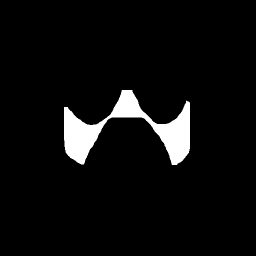

In [51]:
mask = Image.open(mask_path_fair).convert('L')
mask

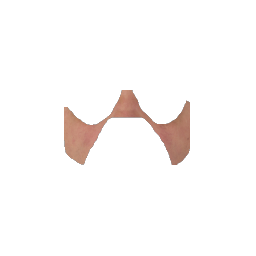

In [52]:
gt = Image.open(gt_albedo_path).convert('RGB')
gt.putalpha(mask)
gt

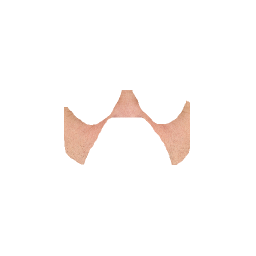

In [53]:
predicted = Image.open(preditcted_albedo_path).convert('RGB')
predicted.putalpha(mask)
predicted

In [54]:
# Ensure all images are the same size
mask = mask.resize(predicted.size)
mask_np = np.array(mask)

# Apply mask and convert PIL Images to NumPy arrays
gt.putalpha(mask)
predicted.putalpha(mask)
gt_np = np.array(gt)[:, :, :3]  # Drop alpha channel
predicted_np = np.array(predicted)[:, :, :3]  # Drop alpha channel

# Calculate ITA for both images, applying the mask
ita_gt = calculate_ita(gt_np, mask_np)
ita_predicted = calculate_ita(predicted_np, mask_np)

# Compute mean difference in ITA where neither is NaN
valid_mask = ~np.isnan(ita_gt) & ~np.isnan(ita_predicted)
mean_ita_difference = np.nanmean(np.abs(ita_gt[valid_mask] - ita_predicted[valid_mask]))

print("Mean ITA Difference:", mean_ita_difference)

Mean ITA Difference: 31.350981370921215


In [55]:
# Classify skin types based on ITA
skin_types = classify_skin_type(ita_gt)

# Example usage: print the unique skin types identified in the image
unique_skin_types = np.unique(skin_types[~np.isnan(ita_gt)])
print("Identified Skin Types:", unique_skin_types)

Identified Skin Types: ['Type II (Light)' 'Type III (Intermediate)' 'Type IV (Dark)'
 'Type V (Brown)' 'Type VI (Black)']
